In [25]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

## Load extracted features and df

In [3]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [4]:
from utils.inverted_encoding import FeatureDowngrade

d2_H, d2_W = 15, 15
DEFAULT_FEATURE_CONV_CONFIG = {
    '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

DEFAULT_FEA_CONVERTER = FeatureDowngrade(DEFAULT_FEATURE_CONV_CONFIG)

In [5]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True, converter=DEFAULT_FEA_CONVERTER):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)

    # apply conversion if needed
    if converter is not None:
        features = converter.get_converted_features(features)
        
    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [6]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

## Precompute the difference table

In [7]:
from utils.distrib import ValueRangeManager, OriDistribModel, incorporate_distributions
from copy import deepcopy

example_base_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
value_manager = ValueRangeManager(np.arange(180))
base_distrib = OriDistribModel(value_manager, example_base_params)

In [8]:
all_oris = np.arange(180)
all_distrib = base_distrib.loc(all_oris)

In [9]:
# apply some smoothing
from scipy.ndimage import gaussian_filter1d

def gaussian_filter_distrib(distrib, sigma):
    smoothed = gaussian_filter1d(distrib, sigma=sigma, axis=1, mode='wrap')
    smoothed = smoothed / np.sum(smoothed, axis=1, keepdims=True)
    return smoothed

# all_distrib = gaussian_filter_distrib(all_distrib, sigma=15)

In [10]:
from scipy.spatial.distance import pdist, cdist, jensenshannon, squareform

def precomput_stim_dists(distrib, method):
    if method == 'jsd':
        dists = squareform(pdist(distrib, metric=jensenshannon))
        dists = dists / np.log(2)
    elif method == 'cos':
        distrib_normalized = distrib / np.linalg.norm(distrib, axis=1, keepdims=True)
        similarity = np.dot(distrib_normalized, distrib_normalized.T)
        dists = 1 - similarity
    elif method == 'euc':
        dists = cdist(distrib, distrib, 'euclidean')
    else:
        raise ValueError(f'Unknown method {method}')

    return dists

(array([  636.,   614.,   644.,   584.,   654.,   620.,   624.,   654.,
          672.,   672.,   718.,   736.,   798.,   844.,   918.,   998.,
         1142.,  1408.,  2364., 16100.]),
 array([0.        , 0.05217422, 0.10434844, 0.15652265, 0.20869687,
        0.26087109, 0.31304531, 0.36521952, 0.41739374, 0.46956796,
        0.52174218, 0.5739164 , 0.62609061, 0.67826483, 0.73043905,
        0.78261327, 0.83478748, 0.8869617 , 0.93913592, 0.99131014,
        1.04348435]),
 <BarContainer object of 20 artists>)

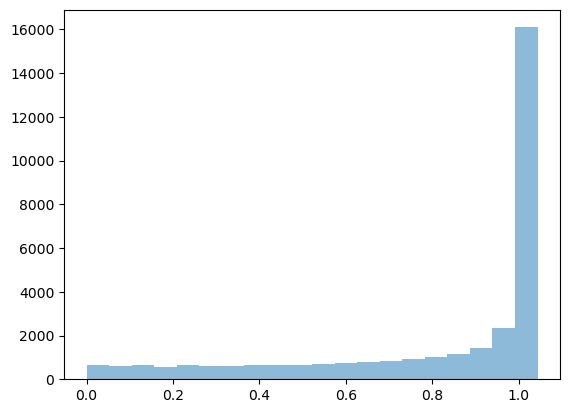

In [11]:
all_ori_dists = precomput_stim_dists(all_distrib, 'jsd')
plt.hist(all_ori_dists.flatten(), bins=20, alpha=0.5)

## Apply RSA within a certain condition

In [12]:
from copy import deepcopy

In [13]:
from utils.rsa import RepresentationModel

distrib_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
RepModel = RepresentationModel(distrib_params)

In [14]:
from utils.rsa import RepRSAHelper

rsa_configs = {
    "channels": 18, # number of channels
    "channel_k": 5, # to compute weight for channels
}
rsa_helper = RepRSAHelper(**rsa_configs, rep_model=RepModel)

In [15]:
from utils.rsa import ALL_TIME_STEPS, raw_conditional_rsa_subj

PLOT_TIME_STEPS = ALL_TIME_STEPS[1:-1]

def conditional_rsa_subj(
        subj, lmb, feature_mask, y_name, feature_dist_method):
    # window_size: 150 ms
    return raw_conditional_rsa_subj(
        subj, lmb, feature_mask, y_name, feature_dist_method,
        load_subject_time_feature, rsa_helper,
        time_steps=PLOT_TIME_STEPS, window_size=3)

In [16]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
feature_mask = np.arange(0, 2)
example_results = conditional_rsa_subj(908, draw_lmb, feature_mask, 'stim_1', 'euc')

## Combine everyone

In [17]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'rsa', 'within_group')

In [18]:
from utils.rsa import raw_get_everyone_corr

def get_everyone_corr(lmb, feature_mask, y_name, feature_dist_method):
    return raw_get_everyone_corr(
        lmb, feature_mask, y_name, feature_dist_method,
        compute_subj_rsa_func=conditional_rsa_subj, 
        subjs=all_subjs)

In [19]:
from collections import OrderedDict
from utils.eye_plotting import annotate_time_line
from utils.eye_trial import generate_events

EVENTS = generate_events()

In [20]:
from utils.rsa import raw_display_conditional_rsa

def display_conditional_rsa(ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, 
        color=None, alpha=1.0, linestyle='-'):
    return raw_display_conditional_rsa(
        ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, 
        color=color, alpha=alpha, linestyle=linestyle,
        get_rsa_corr_func=get_everyone_corr,
        display_time_steps=(PLOT_TIME_STEPS+0.5)*50)

In [21]:
from utils.rsa import raw_display_lmb_dicts_rsa

def display_lmb_dicts_rsa(ax, lmb_dicts, feature_mask, y_name, feature_dist_method, 
        colors=None, alphas=None, linestyles=None, show_legend=True):
    return raw_display_lmb_dicts_rsa(
        ax, lmb_dicts, feature_mask, y_name, feature_dist_method, 
        colors=colors, alphas=alphas, linestyles=linestyles,
        show_legend=show_legend,
        display_rsa_func=display_conditional_rsa)

In [22]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()

In [23]:
ALL_FEATURE_MASKS = OrderedDict([
    # ('mean location', np.arange(0, 2)),
    # ('angle distrib', np.arange(2, 32)),
    ('1d2d', np.arange(32, 68)),
])

ALL_FEATURE_MASK_DIST_METHODS = OrderedDict([
    # ('mean location', 'euc'),
    # ('angle distrib', 'cos'),
    ('1d2d', 'cos'),
])

### sanity check

In [24]:
from utils.rsa import RSA_PLOT_SIZE

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [01:08<00:00,  1.89s/it]


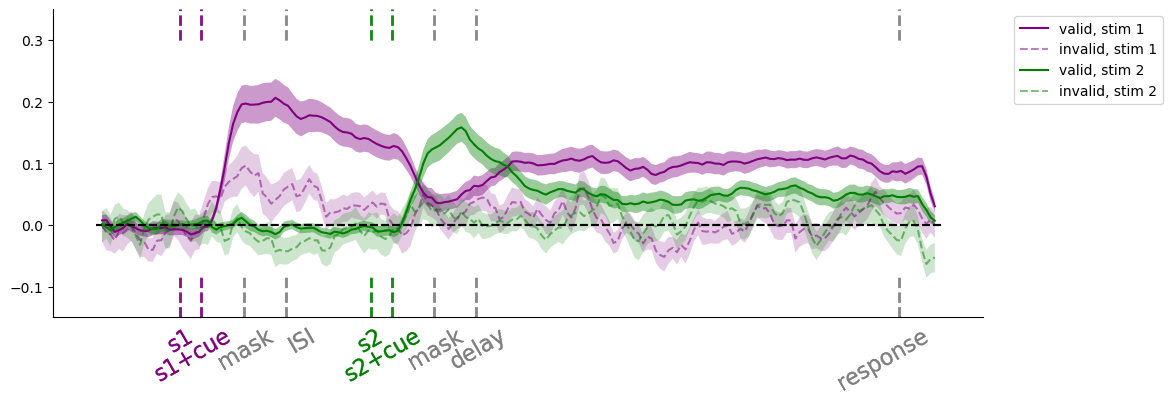

In [ ]:
stim1_valid_lmb = lambda d: ((d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
stim1_invalid_lmb = lambda d: (~(stim1_valid_lmb(d)))
stim2_valid_lmb = lambda d: ((d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
stim2_invalid_lmb = lambda d: (~(stim2_valid_lmb(d)))
valid_masks = {
    'stim_1': {
        'valid, stim 1': stim1_valid_lmb,
        'invalid, stim 1': stim1_invalid_lmb,
    },
    'stim_2': {
        'valid, stim 2': stim2_valid_lmb,
        'invalid, stim 2': stim2_invalid_lmb,
    }
}

valid_colors = {
    'stim_1': {
        'valid, stim 1': '#A96FAE', # 'purple',
        'invalid, stim 1': '#A96FAE', # 'purple',
    },
    'stim_2': {
        'valid, stim 2': '#83B174', # 'green',
        'invalid, stim 2': '#83B174', # 'green',
    }
}

valid_alphas = {
    'stim_1': {
        'valid, stim 1': 1.0,
        'invalid, stim 1': 0.5,
    },
    'stim_2': {
        'valid, stim 2': 1.0,
        'invalid, stim 2': 0.5,
    }
}

valid_linestyles = {
    'stim_1': {
        'valid, stim 1': '-',
        'invalid, stim 1': '--',
    },
    'stim_2': {
        'valid, stim 2': '-',
        'invalid, stim 2': '--',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=RSA_PLOT_SIZE)
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, valid_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=valid_colors[stim_id], 
            alphas=valid_alphas[stim_id],
            linestyles=valid_linestyles[stim_id],
            show_legend=to_show_legend)
        # to_show_legend = False
    # plt.suptitle(f'Compare valid v.s. invalid  ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'basic_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

### mode comparison

In [29]:
draw_stim1_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim1_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
draw_stim2_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim2_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [01:24<00:00,  2.35s/it]


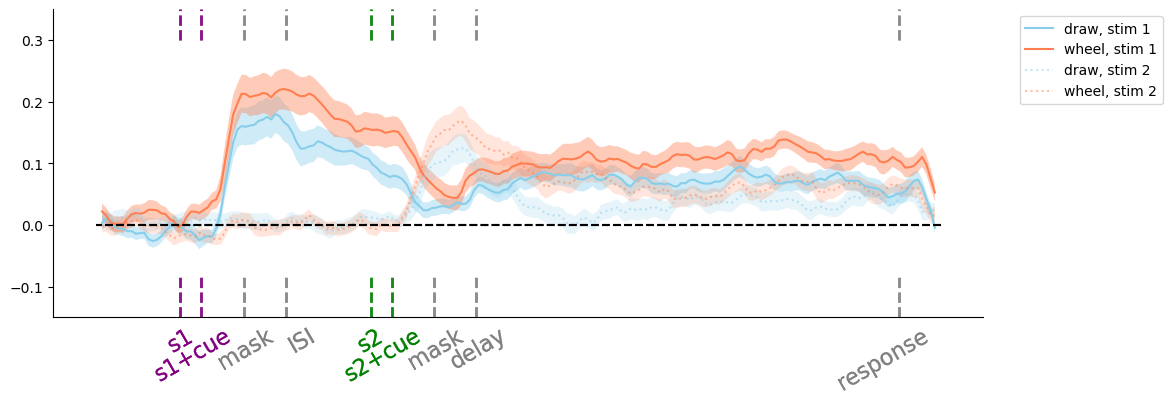

In [ ]:
mode_masks = {
    'stim_1': {
        'draw, stim 1': draw_stim1_lmb,
        'wheel, stim 1': click_stim1_lmb,
    },
    'stim_2': {
        'draw, stim 2': draw_stim2_lmb,
        'wheel, stim 2': click_stim2_lmb,
    }
}

mode_colors = {
    'stim_1': {
        'draw, stim 1': 'skyblue',
        'wheel, stim 1': 'coral',
    },
    'stim_2': {
        'draw, stim 2': 'skyblue',
        'wheel, stim 2': 'coral',
    }
}

mode_alphas = {
    'stim_1': {
        'draw, stim 1': 1.0,
        'wheel, stim 1': 1.0,
    },
    'stim_2': {
        'draw, stim 2': 0.5,
        'wheel, stim 2': 0.5,
    }
}

mode_linestyles = {
    'stim_1': {
        'draw, stim 1': '-',
        'wheel, stim 1': '-',
    },
    'stim_2': {
        'draw, stim 2': ':',
        'wheel, stim 2': ':',
    }
}

for feature_name in ALL_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=RSA_PLOT_SIZE)
    to_show_legend = True
    for stim_id in ['stim_1', 'stim_2']:
        display_lmb_dicts_rsa(
            ax, mode_masks[stim_id], ALL_FEATURE_MASKS[feature_name], stim_id, 
            ALL_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors[stim_id], 
            alphas=mode_alphas[stim_id], linestyles=mode_linestyles[stim_id],
            show_legend=to_show_legend)
        # to_show_legend = False
    # plt.suptitle(f'Compare draw v.s. wheel ({feature_name})', y=0, fontsize=16, fontweight='bold')

    plot_path = os.path.join(PLOTS_FOLDER, f'stim_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

100%|██████████| 36/36 [01:22<00:00,  2.29s/it]


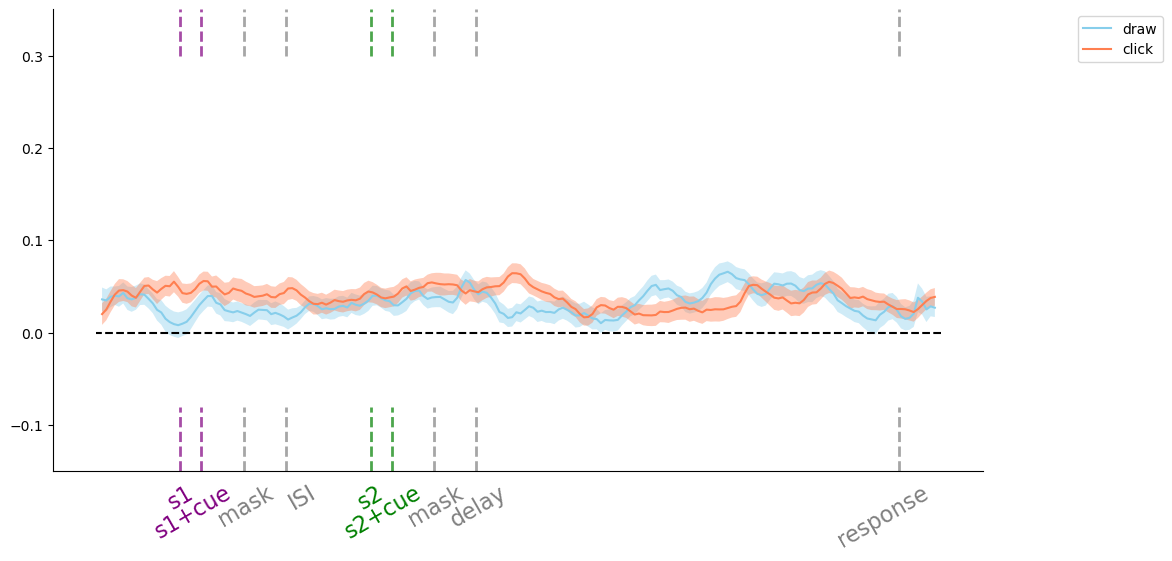

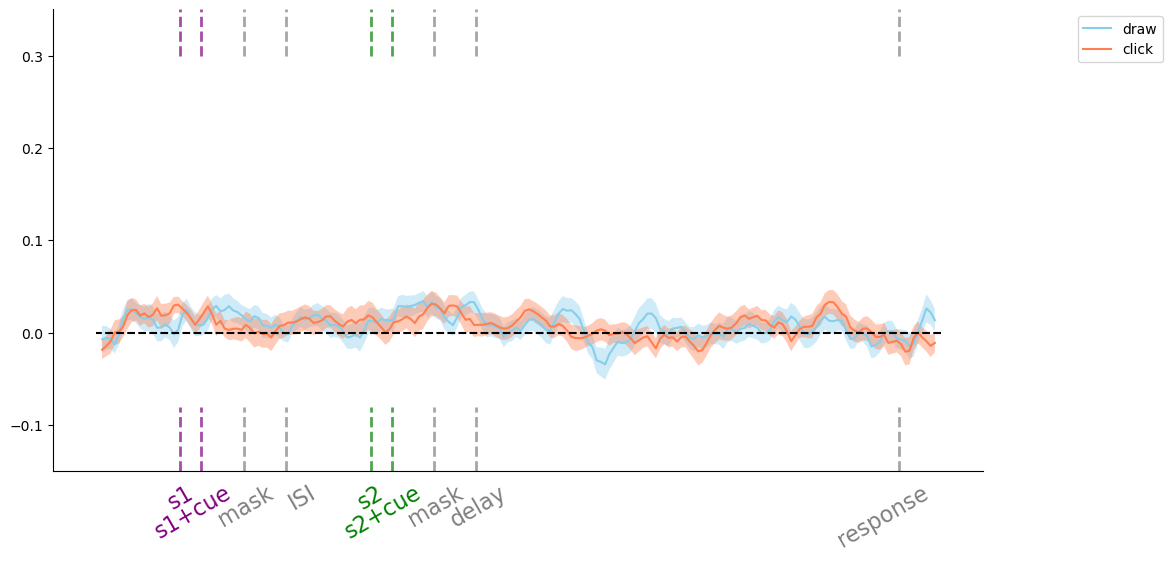

In [ ]:
mode_masks = {
    'draw': draw_lmb,
    'click': click_lmb,
}

mode_colors = {
    'draw': 'skyblue',
    'click': 'coral',
}

SD_FEATURE_MASKS = OrderedDict([
    ('mean location', np.arange(0, 2)),
    ('1d2d', np.arange(32, 68)),
])

SD_FEATURE_MASK_DIST_METHODS = OrderedDict([
    ('mean location', 'euc'),
    ('1d2d', 'cos'),
])


for feature_name in SD_FEATURE_MASKS:
    fig, ax = plt.subplots(1, 1, figsize=RSA_PLOT_SIZE)
    display_lmb_dicts_rsa(
        ax, mode_masks, SD_FEATURE_MASKS[feature_name], 'prev_last_response', 
        SD_FEATURE_MASK_DIST_METHODS[feature_name], colors=mode_colors)
    # plt.suptitle(f'Compare draw v.s. click (last resp) ({feature_name})', y=0, fontsize=16, fontweight='bold')
    
    plot_path = os.path.join(PLOTS_FOLDER, f'last-resp_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

In [32]:
s1_cued_only = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & ~(df['stim_2_to_report'])).to_numpy()
both_cued_lmb = lambda df: ((df['trial_code']==0) & (df['stim_1_to_report']) & (df['stim_2_to_report'])).to_numpy()
null_cue_lmb = lambda df: (df['trial_code']==1).to_numpy()

### Split by SD distance

In [33]:
from collections import OrderedDict

def series_angular_diff(x1, x2):
    diffs = np.abs(x1.to_numpy() - x2.to_numpy())
    diffs_2 = 180 - diffs
    actual_diffs = np.min([diffs, diffs_2], axis=0)
    return actual_diffs

sd_masks = {}
sd_val_groups = OrderedDict([
    ('small', (0, 30)),
    ('small-medium', (15, 45)),
    ('medium', (30, 60)),
    ('medium-large', (45, 75)),
    ('large', (60, 90)),
])
for stimid in ['stim_1', 'stim_2']:
    stim_sd_masks = sd_masks.setdefault(stimid, {})
    for sd_name, (low, high) in sd_val_groups.items():
        stim_sd_masks[f'{sd_name}'] = (lambda d, low=low, high=high, stimid=stimid: 
            (
                (series_angular_diff(d[stimid], d['prev_last_response']) >= low) &
                (series_angular_diff(d[stimid], d['prev_last_response']) < high) &
                (d[f'{stimid}_to_report'] | (d['trial_code'] == 1))
            ).to_numpy()
        )

In [34]:
exp_csv = pd.read_csv(os.path.join(DEFAULT_FEATURE_FOLDER, '908', 'behavior.csv'))
print(exp_csv[['stim_1', 'prev_last_response']].head())
exp_mask_lmb = sd_masks['stim_1']['large']
exp_mask = exp_mask_lmb(exp_csv)
print(exp_csv[exp_mask][['stim_1', 'prev_last_response']].head())


       stim_1  prev_last_response
0   53.768502                 NaN
1   95.392638                54.0
2  169.828842               148.0
3   59.178761               163.0
4  114.967475                53.0
       stim_1  prev_last_response
3   59.178761               163.0
8   62.542754               168.0
16  94.165023                22.0
18  69.226384               161.0
19  79.673512                13.0


In [ ]:
def plot_stim_sd_rsa(feature_name, target_stim_id, target_stim_name, cmap):
    # set color scale
    condition_shades = [cmap(i) for i in np.linspace(0.3, 0.8, len(sd_val_groups))]
    condition_shades = dict(zip(sd_val_groups.keys(), condition_shades))

    fig, ax = plt.subplots(1, 1, figsize=RSA_PLOT_SIZE)
    to_show_legend = True
    display_lmb_dicts_rsa(
        ax, sd_masks[target_stim_id], 
        SD_FEATURE_MASKS[feature_name], target_stim_id, 
        SD_FEATURE_MASK_DIST_METHODS[feature_name], 
        colors=condition_shades, show_legend=to_show_legend)
    to_show_legend = False

    # plt.suptitle(f'Compare different sd ({target_stim_name}) ({feature_name})', y=0, fontsize=16, fontweight='bold')
    plot_path = os.path.join(PLOTS_FOLDER, f'sd_stim_{target_stim_name}_{feature_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [01:08<00:00,  1.90s/it]


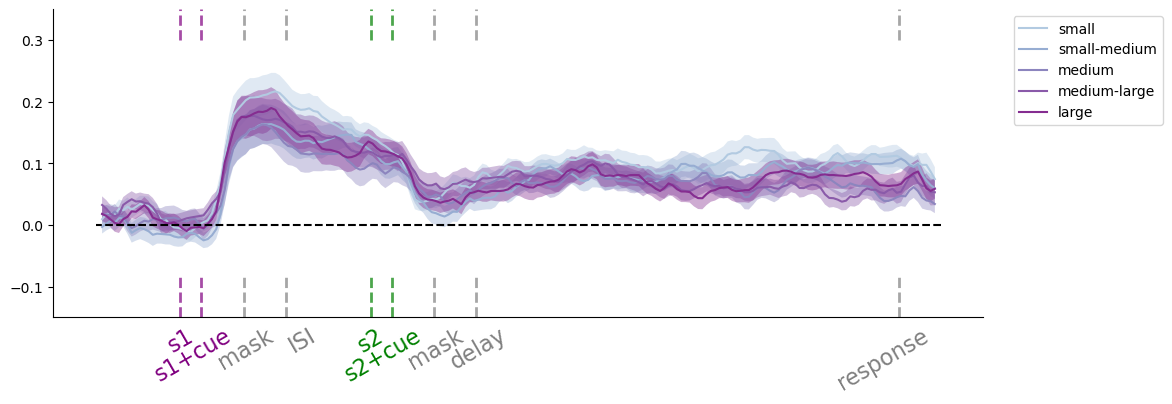

In [38]:
cmap = plt.get_cmap("BuPu")
plot_stim_sd_rsa('mean location', 'stim_1', 'stim 1', cmap)

100%|██████████| 36/36 [01:12<00:00,  2.02s/it]


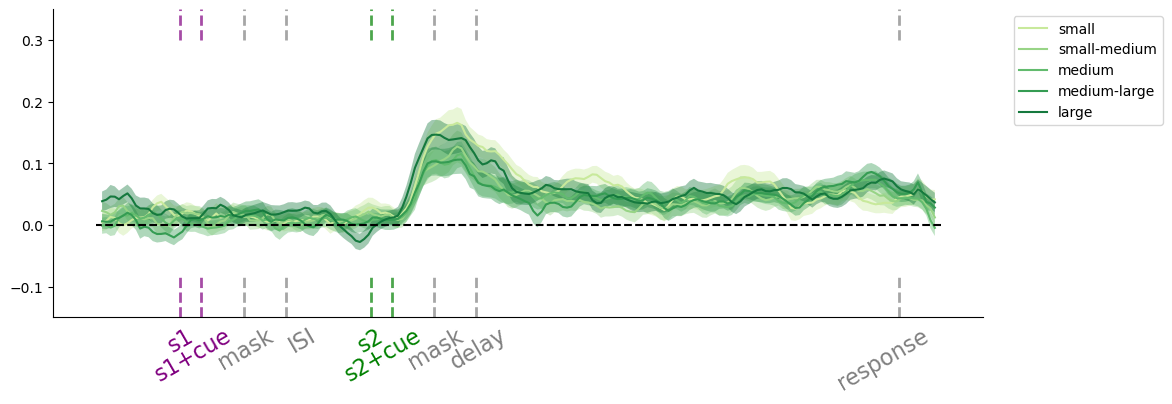

In [39]:
cmap = plt.get_cmap("YlGn")
plot_stim_sd_rsa('mean location', 'stim_2', 'stim 2', cmap)